# Max McKie
# PHYS 403 Final

In [12]:
import math
import numpy as np
import emcee
import corner
import numdifftools as ndt
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp, nquad
from scipy.optimize import minimize

# Part A

In [13]:
#reading data file
a = np.genfromtxt('hd_2039_rv.txt',skip_header=1)

In [14]:
#making data arrays
t = a.T[0] #days
v = a.T[1] #m/s
dv = a.T[2] 

In [15]:
#Making all necessary functions below - just math
def dthetadt(theta,t,tau,eps,w,chi):
    theta0=chi*tau
    num = 2*np.pi*(1+eps*np.cos(theta))**2
    denom = tau*(1-eps**2)**(3/2)
    return num/denom

In [16]:
def theta(chi,tau,t,k,eps,w):
    theta0=chi*tau
    return odeint(dthetadt,theta0,t, args = (tau,eps,w,chi)).T

In [17]:
def Vpred(vsys,k,thetas,eps,w):
    return vsys+k*(np.cos(thetas+w)+eps*np.cos(w))

def Vi(params):
    vsys,tau,k,eps,w,chi,b = params
    thetas = theta(chi,tau,t,k,eps,w).T
    thetas = np.reshape(thetas,36)
    
    return vsys+k*(np.cos(thetas+w)+eps*np.cos(w))

In [18]:
#negative log likelihood
def loglike(params):
    vsys,tau,k,eps,w,chi,b = params
    N = 36 #number of data points
    
    thetas = theta(chi,tau,t,k,eps,w).T
    thetas = np.reshape(thetas,36)
    
    term1 = (N/2)*np.log(b/(2*np.pi))
    
    term2 = -np.sum(np.log(dv))
    
    term3 = -(b/2)*np.sum( ((v-Vpred(vsys,k,thetas,eps,w))/dv)**2 )

    return -(term1+term2+term3)

In [19]:
#initial guesses...after so, so much pre-initial guessing
vsys = 30 
tau = 1200
k = 50
eps = .6
w = 4
chi = .05
b= 1.4

p0 = [vsys,tau,k,eps,w,chi,b]
res = minimize(loglike,p0,method = "L-BFGS-B", bounds= [[-100,100], [10,1500],[1,200],[1e-3,.999],[1e-3,2*np.pi],[1e-3,.999],[.01,8]])

In [20]:
#feeding random seeds to minimizer based off of last result to get a better fit
vsys_init = list(vsys+ np.random.uniform(-5,5,15))
tau_init = list(tau+ np.random.uniform(-150,150,15))
k_init = list(k+ np.random.uniform(-10,10,15))
eps_init = list(eps+ np.random.uniform(-.2,.2,15))
w_init = list(w+ np.random.uniform(-1,1,15))
chi_init = list(chi+ np.random.uniform(-.04,.04,15))
b_init = list(b+ np.random.uniform(-.8,.8,15))

pos = vsys_init, tau_init, k_init, eps_init, w_init, chi_init, b_init

loglikes = np.inf
result=1

#choosing best parameters out of random seeds
for i in range(15):
    val =  minimize(loglike,np.array(pos).T[i],method = "L-BFGS-B", bounds= [[-100,100], [10,1500],[1,200],[1e-3,.999],[1e-3,2*np.pi],[1e-3,.999],[.01,8]])
    if val.fun < loglikes:
        loglikes = val.fun
        result = val.x


In [21]:
#random seeds based off second fit
vsys2 = list(result[0]+ np.random.uniform(-3,3,15))
tau2 = list(result[1]+ np.random.uniform(-100,100,15))
k2 = list(result[2]+ np.random.uniform(-7,7,15))
eps2 = list(result[3]+ np.random.uniform(-.2,.2,15))
w2 = list(result[4]+ np.random.uniform(-.8,.8,15))
chi2 = list(result[5]+ np.random.uniform(-.04,.04,15))
b2 = list(result[6]+ np.random.uniform(-.8,.8,15))

pos2 = vsys2, tau2, k2, eps2, w2, chi2, b2

loglikes2 = np.inf
result2=1
for i in range(15):
    val =  minimize(loglike,np.array(pos2).T[i],method = "L-BFGS-B", bounds= [[-100,100], [10,1500],[1,200],[1e-3,.999],[1e-3,2*np.pi],[1e-3,.999],[.01,8]])
    if val.fun < loglikes:
        loglikes2 = val.fun
        result2 = val.x

if type(result2) is int: print('No better values attained- try again')

In [22]:
#same thing again, just to make extra sure my fit turns out ok
vsys3 = list(result2[0]+ np.random.uniform(-1,1,15))
tau3 = list(result2[1]+ np.random.uniform(-75,75,15))
k3 = list(result2[2]+ np.random.uniform(-4,4,15))
eps3 = list(result2[3]+ np.random.uniform(-.2,.2,15))
w3 = list(result2[4]+ np.random.uniform(-.5,.5,15))
chi3 = list(result2[5]+ np.random.uniform(-.03,.03,15))
b3 = list(result2[6]+ np.random.uniform(-.6,.6,15))

pos3 = vsys3, tau3, k3, eps3, w3, chi3, b3

loglikes3 = np.inf
result3=1
for i in range(15):
    val =  minimize(loglike,np.array(pos3).T[i],method = "L-BFGS-B", bounds= [[-100,100], [10,1500],[1,200],[1e-3,.999],[1e-3,2*np.pi],[1e-3,.999],[.01,8]])
    if val.fun < loglikes:
        loglikes3 = val.fun
        result3 = val.x
        hess3 = val.hess_inv
        
if type(result3) is int: print('No better values attained- try again')

In [23]:
#just checking the change in my successive attempts + final output
loglikes, loglikes2, loglikes3, result3

(156.7615089386563,
 155.3227567204904,
 150.18705281115487,
 array([-4.40849482e+00,  1.10888556e+03,  7.70117908e+01,  5.84589265e-01,
         5.94752893e+00,  1.86074644e-03,  6.11798230e-01]))

In [24]:
#getting uncertainties from Hessian, modeled from class github
def posloglike(params):
    vsys,tau,k,eps,w,chi,b = params
    N = 36 #number of data points
    
    thetas = theta(chi,tau,t,k,eps,w).T
    thetas = np.reshape(thetas,36)
    
    term1 = (N/2)*np.log(b/(2*np.pi))
    
    term2 = -np.sum(np.log(dv))
    
    term3 = -(b/2)*np.sum( ((v-Vpred(vsys,k,thetas,eps,w))/dv)**2 )
    
    return (term1+term2+term3)


hessian = ndt.Hessian(posloglike)
hess_l1 = hessian(result3)
hess_inv=np.linalg.inv(hess_l1)

uncertainty = np.sqrt(np.diag(-hess_inv))

labels = ['V_sys', 'Tau', 'Kappa', 'Epsilon', 'w', 'X','b']

#printing best fit values with uncertainty
for i in range(7):
    print('{:<4s} = {:9.4f} +- {:6.4f}'.format(labels[i], result3[i], uncertainty[i]))

/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


V_sys =   -4.4085 +- 3.5069
Tau  = 1108.8856 +- 10.0755
Kappa =   77.0118 +- 5.8912
Epsilon =    0.5846 +- 0.0404
w    =    5.9475 +- 0.0937
X    =    0.0019 +-    nan
b    =    0.6118 +- 0.0833


/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/numdifftools/extrapolation.py:489: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:173: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:174: RuntimeWarning: invalid value encountered in greater
  (abs(der) > (a_median * trim_fact))) * (a_median > 1e-8) +
/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/numdifftools/limits.py:175: RuntimeWarning: invalid value encountered in less
  ((der < p25 - 1.5 * iqr) + (p75 + 1.5 * iqr < der)))
/Users/maxmckie/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


# Part B

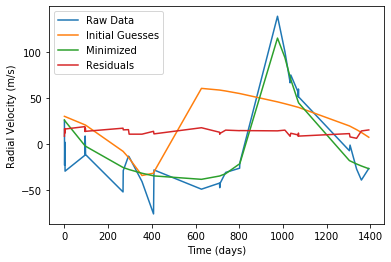

In [25]:
plt.plot(t,v, label='Raw Data')
plt.plot(t,Vi(p0), label='Initial Guesses')
plt.plot(t,Vi(result3),label= 'Minimized')
plt.plot(t,dv,label = 'Residuals')
plt.xlabel('Time (days)')
plt.ylabel('Radial Velocity (m/s)')
plt.legend()
plt.show()

#### The data does seem to be a good fit, and the residual curve is roughly constant across the entire data set. However, although it is flat, it is also positive, meaning our measured velocity is more than the predicted velocity by an approximately constant amount. This could stem from a source of systematic error in the experiment.

# Part C

In [26]:
vsys_best,tau_best,k_best,eps_best,w_best,chi_best,b_best = result3

asini = 1.38e-5*k_best*tau_best*np.sqrt(1-eps_best**2)

sigtau,sigk,sigeps = uncertainty[1],uncertainty[2],uncertainty[3]

#did these derivatives by hand
dadtau = (1.38e-5)*k_best*np.sqrt(1-eps_best**2)
dadk = (1.38e-5)*tau_best*np.sqrt(1-eps_best**2)
dadeps = (1.38e-5)*k_best*tau_best*eps_best*(np.sqrt(1-eps_best**2)**(-.5))

#error propagation
sigA = (dadtau**2)*(sigtau**2) +(dadk**2)*(sigk**2) + (dadeps**2)*(sigeps**2)


Msini = (4.92e-3)*(.98**(2/3))*k_best*(tau_best**(1/3))*np.sqrt(1-eps_best**2)

#did these derivatives by hand
dMdtau = (4.92e-3)*(.98**(2/3))*k_best*(1/3)*(tau_best**(-2/3))*np.sqrt(1-eps_best**2)
dMdk = (4.92e-3)*(.98**(2/3))*(tau_best**(1/3))*np.sqrt(1-eps_best**2)
dMdeps = (4.92e-3)*(.98**(2/3))*k_best*(tau_best**(1/3))*eps_best/np.sqrt(1-eps_best**2)
dMdMstar = (4.92e-3)*(.98**(-1/3))*(2/3)*k_best*(tau_best**(1/3))*np.sqrt(1-eps_best**2)

sigMst = .05

#error propagation
sigM = (dMdtau**2)*(sigtau**2) +(dMdk**2)*(sigk**2) + (dMdeps**2)*(sigeps**2) +(dMdMstar**2)*(sigMst**2)


aTrue, Mtrue = 1.56, 4.9
print('asini=',asini,'+-',sigA,' [x10^6 km]')
print('Msini=',Msini,'+-',sigM,' [M_J]')
print('\nMy values for asini and Msini are both roughly 2/3 of the reported values, respectively.')
print('\nNot great but not so bad for astro, I hear :)')

asini= 0.9561372756651444 +- 0.006380296559950389  [x10^6 km]
Msini= 3.139297668084681 +- 0.08185319982416459  [M_J]

My values for asini and Msini are both roughly 2/3 of the reported values, respectively.

Not great but not so bad for astro, I hear :)


# Part D

In [27]:
#Priors
def logUniprior(eps,w,chi):
    
    if 0<=eps<=.99 and 0 <= w <= 2*np.pi and 0<= chi <=1:
        return 0
    return -np.inf

def logJefftau(tau):
    if 10< tau < 1500:
        return np.log((1/tau)/(np.log(150)))
    return -np.inf

def logJeffkap(k):
    if 1< k < 200:
        return np.log( (1/k)/(np.log(200)) )
    return -np.inf

def logJeffb(b):
    if .01 < b < 8:
        return np.log( (1/b)/(np.log(800)) )
    return -np.inf

In [28]:
#generating seeds for MCMC chains
vsys_mc = vsys_best+ .05*np.random.random(32)
tau_mc = tau_best+ 75*np.random.random(32)
k_mc = k_best+ .7*np.random.random(32)
eps_mc = eps_best+ .02*np.random.random(32)
w_mc = w_best+ .2*np.random.random(32)
chi_mc = chi_best+ 1e-4*np.random.random(32)
b_mc = b_best+ .02*np.random.random(32)

In [29]:
#logprob with priors included
def logprobpri(params):
    vsys,tau,k,eps,w,chi,b = params
    
    priUni = logUniprior(eps,w,chi)
    pritau = logJefftau(tau)
    prik = logJeffkap(k)
    prib = logJeffb(b)
    
    logpri= priUni+ pritau + prik + prib
    if not np.isfinite(logpri):
        return -np.inf
    return logpri - loglike(params)

In [30]:
posmc = np.zeros((32,7))

posmc[:,0] = vsys_mc
posmc[:,1] = tau_mc
posmc[:,2] = k_mc
posmc[:,3] = eps_mc
posmc[:,4] = w_mc
posmc[:,5] = chi_mc
posmc[:,6] = b_mc

nwalkers, ndim = 32,7

#actually running MCMC
sampler = emcee.EnsembleSampler(nwalkers,ndim,logprobpri)
sampler.run_mcmc(posmc,13000,progress=True);

100%|██████████| 13000/13000 [16:49<00:00, 12.88it/s]


Text(0.5, 0, 'Steps')

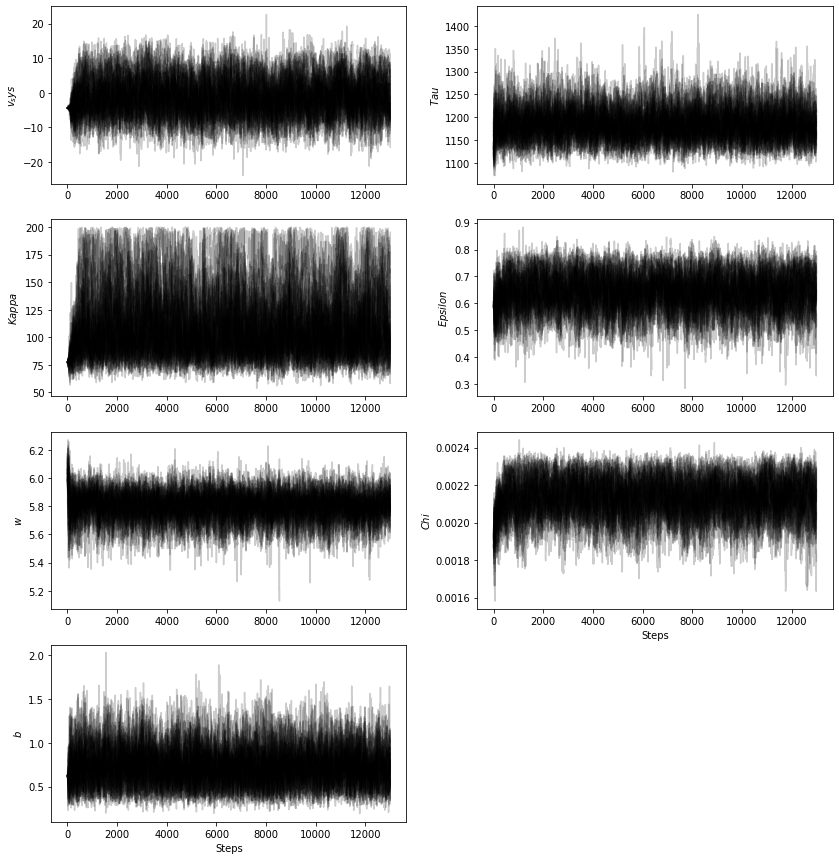

In [31]:
#Plotting MCMC chains
plt.figure(figsize=(14,15))

plt.subplot(421)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,0], 'k', alpha=.2)
plt.ylabel('$v_sys$')


plt.subplot(422)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,1], 'k', alpha=.2)
plt.ylabel('$Tau$')


plt.subplot(423)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,2], 'k', alpha=.2)
plt.ylabel('$Kappa$')


plt.subplot(424)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,3], 'k', alpha=.2)
plt.ylabel('$Epsilon$')


plt.subplot(425)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,4], 'k', alpha=.2)
plt.ylabel('$w$')


plt.subplot(426)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,5], 'k', alpha=.2)
plt.ylabel('$Chi$')
plt.xlabel('Steps')

plt.subplot(427)
for i in range(0,32):
    plt.plot(sampler.chain[i][:,6], 'k', alpha=.2)
plt.ylabel('$b$')
plt.xlabel('Steps')


In [32]:
tau = sampler.get_autocorr_time()
tau

array([224.65342977, 144.17397745, 258.25367171, 226.1653268 ,
       126.22552035, 234.84277143, 125.60662709])

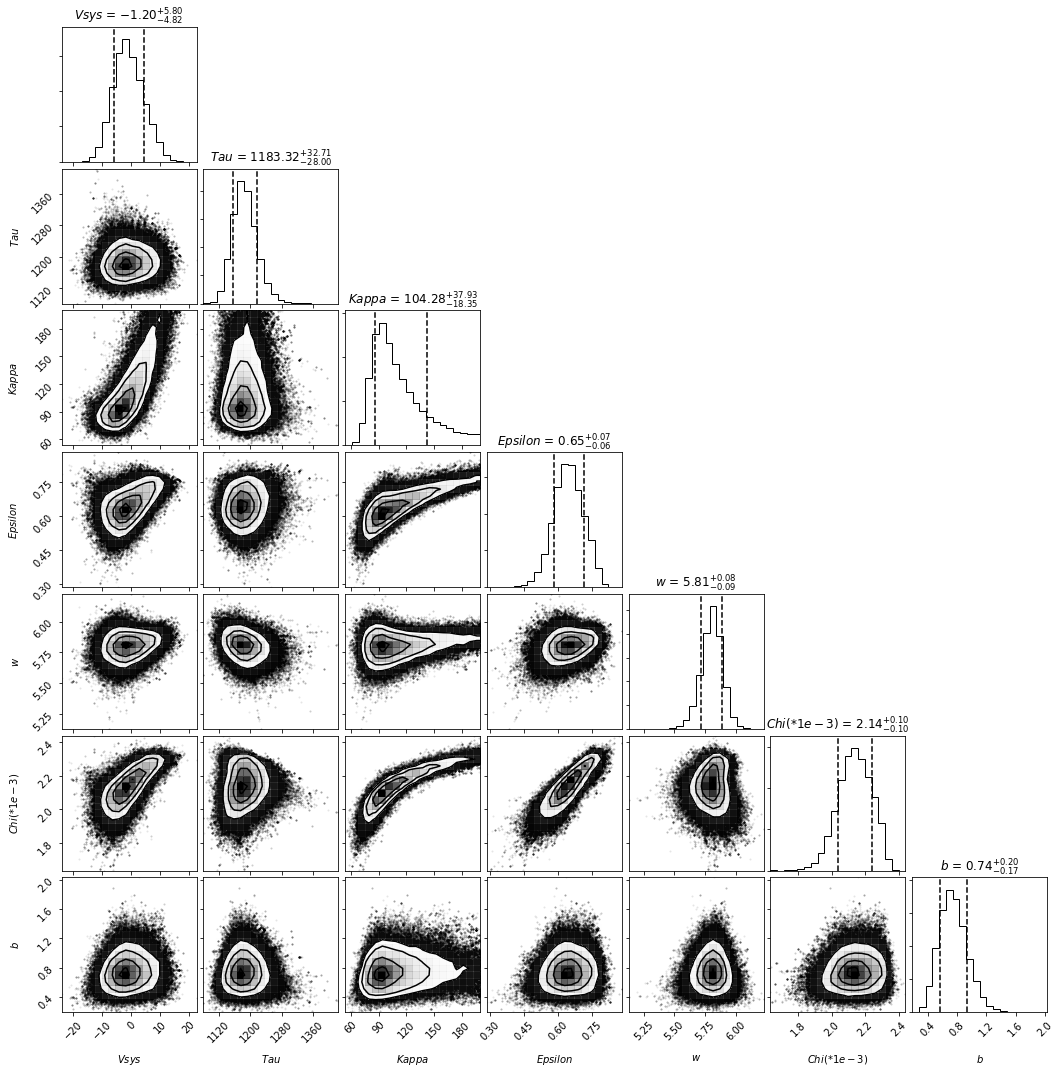

In [33]:
#flatten chains, discard first ~4*tau steps and make corner plots
flat_samples = sampler.get_chain(discard=int(1000), thin=14, flat=True)
allsamples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
allsamples[:,5] = 1e3*allsamples[:,5]
fig = corner.corner(allsamples, labels=["$Vsys$", "$Tau$","$Kappa$","$Epsilon$","$w$","$Chi(*1e-3)$","$b$"], quantiles = [.16,.84], show_titles=True)
fig.set_size_inches(15,15)

# Part E

In [34]:
def pdf(vsys,b):
    N=36
    term1 = (b/(2*np.pi))**(N/2)
    term2 = np.prod(1/dv)
    term3 = np.exp((-b/2)*np.sum( (v-vsys)**2/(dv**2)) )
    return term1*term2*term3

vsysPri = 1/200

def Jeffb(b):
    if .01<= b <= 8:
        return (1/b)/(np.log(800))
    return 0

def intpdf(vsys,b):
    reg = pdf(vsys,b)
    Jb = Jeffb(b)
    return vsysPri*Jb*reg

In [35]:
#Making/integrating variable axes to get likelihood
vint,bint = np.meshgrid(np.linspace(-100,100,500), np.linspace(.01,8,500))

grid= np.zeros_like(vint)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        grid[i][j] = intpdf(vint[i][j],bint[i][j])
                                                                                                    
final = np.trapz(np.trapz(grid,dx=(2/5),axis=0),dx=(7.99/500),axis=0)
print('p(D|M0)= ',final)

p(D|M0)=  3.8991898617166604e-86


# Part F

In [ ]:
def Jefftau(tau):
    if 10<= tau <= 1500:
        return (1/tau)/(np.log(150))
    return 0

def Jeffk(k):
    if 1<= k <= 200:
        return (1/k)/(np.log(200))
    return 0


def intpdf2(vsys,tau,k,eps,w,chi,b):
    params= vsys,tau,k,eps,w,chi,b
    nopris = np.exp(-1*loglike(params))
    unifs = (1/.99)/(2*np.pi)
    jeffb = Jeffb(b)
    jeffk = Jeffk(k)
    jefft = Jefftau(tau)
    return nopris*unifs*jeffb*jeffk*jefft
    

In [ ]:
final2 = nquad(intpdf2,[[-100,100],[10,1500],[1,200],[1e-3,.999],[0,2*np.pi],[1e-3,.999],[.01,8]])

print('p(D|M1) = {0:.4e}'.format(final2))

#### I let the above cell run for ~10 hours with no output, so I decided to use the method below (recommended by Spencer), and even this one ran for ~5 hours without  getting to the lines where I call np.trapz. If I had time to let either of these methods run for much longer, they would both spit out P(D|M1). Then, since I already have P(D|M0) above, I could compute the Bayes factor pretty quick. It's too bad I don't have an at-home super computer :/

In [ ]:
##  Setting up integration range and evaluating pdf
vsys_range = np.arange(-100.,100., 4)
tau_range = np.arange(10.,1500., 15)
k_range = np.arange(1.,200., 2)
eps_range = np.arange(1e-3,.999, 0.03)
w_range = np.arange(0,2*np.pi, .1)
chi_range = np.arange(1e-3,.999, 0.03)
b_range = np.arange(.01,8., 0.2)

pdfans = np.zeros(shape=(vsys_range.size, tau_range.size, k_range.size,eps_range.size,w_range.size,chi_range.size,b_range.size))

for i, vsys_i in enumerate(vsys_range):
    for j, tau_j in enumerate(tau_range):
        for k, k_k in enumerate(k_range):
            for l, eps_l in enumerate(eps_range):
                for m, w_m in enumerate(w_range):
                    for n, chi_n in enumerate(chi_range):
                        for o, b_o in enumerate(b_range):
                            pdfans[i,j,k,l,m,n,o] = intpdf2(vsys_i,tau_j,k_k,eps_l,w_m,chi_n,b_o)



## Evaluating integral
int1 = np.trapz(pdfans, b_range, axis=6)
int2 = np.trapz(int1,chi_range, axis = 5)
int3 = np.trapz(int2,w_range,axis=4)
int4 = np.trapz(int3,eps_range,axis=3)
int5 = np.trapz(int4,k_range,axis=2)
int6 = np.trapz(int5,tau_range,axis=1)
probans = np.trapz(int6,vsys_range,axis=0)

print('p(D|M1) = {0:.4e}'.format(probans))